<h1><span style="color:blue; font-weight:bold"><u><center>HOF Data Exploration/Organization</center></u></span></h1>

<p><span style="color:green; font-weight:bold">The following notebook gives a glimpse into the kind of data we are working with, more specifically the variables that we want to use in a future model. The datasets utilized will be properly preprocessed and formatted so that they are applicable to all functionality. Criteria for filtering will be explained and at the end there will be two remaining datasets, one for retired-eligible players and the other for currently active players. Additionally, correlation calculations will be run along with some visuals of the data to get a view of its behavior. All stats are pulled from BaseballReference.com and Stathead.com</span></p>

In [1]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_transformer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from scipy.stats import uniform
from scipy.stats import randint
from sklearn.svm import SVR
from statistics import mean
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.express as px
from scipy import stats
import seaborn as sns
import pandas as pd
import numpy as np
import sqlite3
import joblib
import random 
import math

In [2]:
def read_and_encode(file):
    blank = pd.read_csv(file, encoding='ISO-8859-1')
    blank = blank.replace({'Â': '', 'Ã©': 'é', 'Ã': '', '±': 'ñ'}, regex=True)
    return blank

pd.options.mode.chained_assignment = None

col_order = ['Player', 'Team', 'Season', 'Age', 'G', 'PA', 'AB',
       'R', 'H', '1B', '2B', '3B', 'HR', 'RBI', 'XBH', 'SB', 'CS', 'BB', 'SO', 'BA',
       'OBP', 'SLG', 'OPS', 'TB', 'GIDP', 'HBP', 'SH', 'SF', 'IBB',
       'WAR', 'Pos']

players_hof = pd.read_csv('Hall of Fame by Seasons.csv', encoding='utf-8')
players_hof = players_hof.replace({'Â': '', 'Ã©': 'é', 'Ã': '', '±': 'ñ', '©': 'é', '':'Á', 'º': 'ú'}, regex=True)
players_hof = players_hof.drop(players_hof.columns[0], axis=1)
players_hof = players_hof.iloc[:-2]
players_hof = players_hof[col_order]
hof_total = pd.read_csv('Hall of Fame.csv', encoding='utf-8')

players_retired = pd.read_csv('Retired Players by Seasons.csv', encoding='utf-8', index_col=0)
players_retired.index.name = None
players_retired = players_retired.replace({'Â': '', 'Ã©': 'é', 'Ã': '', '±': 'ñ', '':'Á', 'º': 'ú', '©': 'é'}, regex=True)
players_retired = players_retired[col_order]
retired_total = pd.read_csv('Retired.csv', encoding='utf-8')

players_active = pd.read_csv('Active Player Seasons.csv', encoding='utf-8', index_col=0)
players_active.index.name = None
players_active = players_active.replace({'Â': '', 'Ã©': 'é', 'Ã': '', '±': 'ñ', '©': 'é', '':'Á', 'º': 'ú'}, regex=True)
players_active = players_active[col_order]

temp_stars = pd.read_csv('Full All Stars by Season.csv', encoding='ISO-8859-1')
all_stars = temp_stars.iloc[:, :4].copy()
all_stars.columns = ['Year', 'First', 'Last', 'Position']
all_stars = all_stars.replace({'Â': '', 'Ã©': 'é', 'Ã': '', '±': 'ñ'}, regex=True)
all_stars['Player'] = all_stars['First'] + ' ' + all_stars['Last']
all_stars['Player'] = (all_stars['First'] + ' ' + all_stars['Last']).str.strip()
all_stars = all_stars.drop(['First', 'Last'], axis=1)

al_gg = pd.read_csv('AL Gold Glovers.csv', encoding='utf-8')
al_ss = pd.read_csv('AL Silver Sluggers.csv', encoding='utf-8')
nl_gg = pd.read_csv('NL Gold Glovers.csv', encoding='utf-8')
nl_ss = pd.read_csv('NL Silver Sluggers.csv', encoding='utf-8')
bat_titles = pd.read_csv('Batting Titles.csv', encoding='utf-8')
roy_winners = pd.read_csv('ROY.csv', encoding='utf-8', header=1)
hank_aarons = pd.read_csv('Hank Aaron.csv', encoding='utf-8')
mvp_winners = pd.read_csv('MVP.csv', encoding='utf-8')
ws_mvps = pd.read_csv('WS MVP.csv', encoding='utf-8')

<h2><span style="color:blue; font-weight:bold"><u>Filtering Datasets</u></span></h2>

<p><span style="color:green; font-weight:bold">Data is filtered to make sure it is usable for training. Active players are filtered so that they have at least four seasons in the majors. All retired players are filtered for playing after 1950 and having at least 10 seasons of play. 1950 marks the historical point of the end of segregated leagues and players must have played 10 years for HOF eligiblity.</span></p>

In [3]:
new_active = players_active[players_active['Season'] != 2025]

new_active = new_active.fillna(0)

conn = sqlite3.connect(':memory:')
new_active.to_sql('new_active', conn, index=False, if_exists='replace')

query = """
SELECT *
FROM new_active
WHERE Player IN (
    SELECT Player
    FROM new_active
    GROUP BY Player
    HAVING COUNT(*) >= 4
)
"""

new_active = pd.read_sql_query(query, conn)

new_hof = players_hof.fillna(0)

conn = sqlite3.connect(':memory:')
new_hof.to_sql('new_hof', conn, index=False, if_exists='replace')

query = """
SELECT *
FROM new_hof
WHERE Player IN (
    SELECT Player
    FROM new_hof
    WHERE Season >= 1950
    GROUP BY Player
    HAVING COUNT(*) >= 10
)
"""

new_hof = pd.read_sql_query(query, conn)

new_retired = players_retired.fillna(0)

conn = sqlite3.connect(':memory:')
new_retired.to_sql('new_retired', conn, index=False, if_exists='replace')

query = """
SELECT *
FROM new_retired
WHERE Player IN (
    SELECT Player
    FROM new_retired
    WHERE Season >= 1950
    GROUP BY Player
    HAVING COUNT(*) >= 10
)
"""

new_retired = pd.read_sql_query(query, conn)

<p><span style="color:green; font-weight:bold">The position column is adjusted so that values only refer to the primary position of that season only. Additionally, all retired players are filtered so that the dataframe only contains players with a total WAR of at least 30. Then, both the HOF and retired datasets are combined.</span></p>

In [4]:
def fix_pos(df):
    for i in df.index:
        positions = df.loc[i, 'Pos']
        for char in positions:
            if char.isdigit() or char == 'D':
                if char == 'D':
                    char = '10'
                df.loc[i, 'Pos'] = char
                break

new_retired['Career_WAR'] = new_retired.groupby('Player')['WAR'].transform('sum')

new_retired = new_retired[new_retired['Career_WAR'] >= 30]

new_retired = new_retired.drop(['Career_WAR'], axis=1)

fix_pos(new_retired)
fix_pos(new_hof)
fix_pos(new_active)

inactive_data = pd.merge(new_hof, new_retired, how='outer')

<h2><span style="color:blue; font-weight:bold"><u>Assigning Award Counts</u></span></h2>

<p><span style="color:green; font-weight:bold">The following functions work to assign their respective awards to the correct players in a given dataframe.</span></p>

In [5]:
def check_active(act_temp, year, glover):
    for i in act_temp.index:
        player = act_temp.loc[i]
        name = player['Player'].split()
        if name[1] == glover[0] and int(player['Season']) == int(year):
            if player['Team'] == glover[1]:
                return player['Player'], int(year)
    return None, None

def check_hof(hof_temp, year, glover):
    for i in hof_temp.index:
        player = hof_temp.loc[i]
        name = player['Player'].split()
        if name[1] == glover[0] and int(player['Season']) == int(year):
            if player['Team'] == glover[1]:
                return player['Player'], int(year)
    return None, None

def check_retired(ret_temp, year, glover):
    for i in ret_temp.index:
        player = ret_temp.loc[i]
        name = player['Player'].split()
        if name[1] == glover[0] and int(player['Season']) == int(year):
            if player['Team'] == glover[1]:
                return player['Player'], int(year)
    return None, None

def setup_temps(df):
    df = df.copy()
    df.set_index(df.columns[0], inplace=True)
    team = 'Team'
    if team in df.columns:
        df.drop('Team', axis=1, inplace=True)
    return df

def gg_ss_checks(league, whole, col):
    for i in league.index:
        for j in league.columns:
            if pd.isna(league.loc[i, j]):
                continue
            glover = league.loc[i,j].split('·')
            glover = [item.strip('\xa0') for item in glover]
            year = i.split()
            check_1, season_1 = check_active(new_active, year[0], glover)
            check_2, season_2 = check_hof(new_hof, year[0], glover)
            check_3, season_3 = check_retired(new_retired, year[0], glover)
            if check_1:
                whole.loc[(whole['Player'] == check_1) & (whole['Season'] == season_2), col] += 1
            if check_2:
                whole.loc[(whole['Player'] == check_2) & (whole['Season'] == season_2), col] += 1
            if check_3:
                whole.loc[(whole['Player'] == check_3) & (whole['Season'] == season_3), col] += 1

def simple_awards(df, award_df, award):
    df[award] = 0
    award_df_2 = award_df.copy()

    for i in award_df_2.index:
        player = award_df_2.iloc[i, 2]
        season = award_df_2.iloc[i, 0]
        for j in df.index:
            temp_1 = df.loc[j, 'Player']
            temp_2 = df.loc[j, 'Season']
            if temp_1 == player:
                if temp_2 == season:
                        df.loc[j, award] += 1

<p><span style="color:green; font-weight:bold">The award functions are then applied to both the inactive and active datasets respectively.</span></p>

In [6]:
inactive_data['GGs'] = 0
al_gg_temp = setup_temps(al_gg)
nl_gg_temp = setup_temps(nl_gg)

gg_ss_checks(al_gg_temp, inactive_data, 'GGs')
gg_ss_checks(nl_gg_temp, inactive_data, 'GGs')

inactive_data['SSs'] = 0
al_ss_temp = setup_temps(al_ss)
nl_ss_temp = setup_temps(nl_ss)

gg_ss_checks(al_ss_temp, inactive_data, 'SSs')
gg_ss_checks(nl_ss_temp, inactive_data, 'SSs')

ws_mvps_2 = ws_mvps.copy()
ws_mvps_2.insert(1, 'BlankColumn', pd.NA)
ws_mvps_2['Willie Mays World Series MVP'] = ws_mvps_2['Willie Mays World Series MVP'].str.replace('\xa0S', '')
simple_awards(new_active, ws_mvps_2, 'WS_MVP')
simple_awards(inactive_data, mvp_winners, 'MVPs')

bt_2 = bat_titles.copy()
bt_2['Batting Champ'] = bt_2['Batting Champ'].str.replace('\xa0', ' ')
simple_awards(inactive_data, bt_2, 'Bat_Titles')

as_2 = all_stars.copy()
simple_awards(inactive_data, as_2, 'All_Stars')

In [7]:
new_active = new_active[new_active['Season'] != 2025]
new_active['status'] = 'active'

new_active['GGs'] = 0
al_gg_temp = setup_temps(al_gg)
nl_gg_temp = setup_temps(nl_gg)

gg_ss_checks(al_gg_temp, new_active, 'GGs')
gg_ss_checks(nl_gg_temp, new_active, 'GGs')

new_active['SSs'] = 0
al_ss_temp = setup_temps(al_ss)
nl_ss_temp = setup_temps(nl_ss)

gg_ss_checks(al_ss_temp, new_active, 'SSs')
gg_ss_checks(nl_ss_temp, new_active, 'SSs')

ws_mvps_2 = ws_mvps.copy()
ws_mvps_2.insert(1, 'BlankColumn', pd.NA)
ws_mvps_2['Willie Mays World Series MVP'] = ws_mvps_2['Willie Mays World Series MVP'].str.replace('\xa0S', '')
simple_awards(new_active, ws_mvps_2, 'WS_MVP')
simple_awards(inactive_data, mvp_winners, 'MVPs')

bt_2 = bat_titles.copy()
bt_2['Batting Champ'] = bt_2['Batting Champ'].str.replace('\xa0', ' ')
simple_awards(new_active, bt_2, 'Bat_Titles')

as_2 = all_stars.copy()
simple_awards(new_active, as_2, 'All_Stars')

<h2><span style="color:blue; font-weight:bold"><u>Glimpse into Collinearity</u></span></h2>

<p><span style="color:green; font-weight:bold">The following cell creates a correlation matrix of the variables we are interested in. Each variable will be listed in a dictionary whose values will be a list of its strongly correlated variables.</span></p>

In [8]:
corr_mat = inactive_data.iloc[:,2:].corr()

corr_check = {}
for i in corr_mat.index:
    for j in corr_mat.columns:
        if corr_mat.loc[i, j] >= 0.7:
            if i not in corr_check:
                corr_check[i] = [j]
            else:
                corr_check[i].append(j)
corr_check

{'Season': ['Season'],
 'Age': ['Age'],
 'G': ['G', 'PA', 'AB', 'R', 'H', '1B', '2B', 'RBI', 'XBH', 'TB'],
 'PA': ['G', 'PA', 'AB', 'R', 'H', '1B', '2B', 'RBI', 'XBH', 'BB', 'TB'],
 'AB': ['G', 'PA', 'AB', 'R', 'H', '1B', '2B', 'RBI', 'XBH', 'TB'],
 'R': ['G', 'PA', 'AB', 'R', 'H', '1B', '2B', 'RBI', 'XBH', 'BB', 'TB', 'WAR'],
 'H': ['G', 'PA', 'AB', 'R', 'H', '1B', '2B', 'RBI', 'XBH', 'TB', 'WAR'],
 '1B': ['G', 'PA', 'AB', 'R', 'H', '1B', '2B', 'TB'],
 '2B': ['G', 'PA', 'AB', 'R', 'H', '1B', '2B', 'RBI', 'XBH', 'TB'],
 '3B': ['3B'],
 'HR': ['HR', 'RBI', 'XBH', 'SLG', 'TB'],
 'RBI': ['G', 'PA', 'AB', 'R', 'H', '2B', 'HR', 'RBI', 'XBH', 'SLG', 'TB'],
 'XBH': ['G',
  'PA',
  'AB',
  'R',
  'H',
  '2B',
  'HR',
  'RBI',
  'XBH',
  'SLG',
  'TB',
  'WAR'],
 'SB': ['SB', 'CS'],
 'CS': ['SB', 'CS'],
 'BB': ['PA', 'R', 'BB'],
 'SO': ['SO'],
 'BA': ['BA', 'OBP', 'SLG', 'OPS'],
 'OBP': ['BA', 'OBP', 'SLG', 'OPS'],
 'SLG': ['HR', 'RBI', 'XBH', 'BA', 'OBP', 'SLG', 'OPS'],
 'OPS': ['BA', 'OBP', 'S

<p><span style="color:green; font-weight:bold">The inactive player data is given a 'status' column to seperate the two classes of retired players.</span></p>

In [9]:
inactive_data["status"] = 'retired'

hof_check = []
for i in players_hof.index:
    star = players_hof.loc[i,'Player']
    if star not in hof_check:
        hof_check.append(star)

for i in inactive_data.index:
    player = inactive_data.at[i,'Player']
    if player in hof_check:
        inactive_data.loc[i,'status'] = 'hof'

<h2><span style="color:blue; font-weight:bold"><u>View of Datasets</u></span></h2>

<p><span style="color:green; font-weight:bold">Let's view the datasets now that they are properly formatted and filtered.</span></p>

In [10]:
inactive_data

,Player,Team,Season,Age,G,PA,AB,R,H,1B,...,SF,IBB,WAR,Pos,GGs,SSs,MVPs,Bat_Titles,All_Stars,status
0,Adam Jones,ARI,2019,33,137,528,485,66,126,84,...,3.0,2.0,-0.7,9,0,0,0,0,0,retired
1,Adam Jones,BAL,2008,22,132,514,477,61,129,92,...,5.0,0.0,2.0,8,0,0,0,0,0,retired
2,Adam Jones,BAL,2009,23,119,519,473,83,131,87,...,3.0,3.0,2.6,8,1,0,0,0,1,retired
3,Adam Jones,BAL,2010,24,149,621,581,76,165,116,...,2.0,1.0,2.5,8,0,0,0,0,0,retired
4,Adam Jones,BAL,2011,25,151,618,567,68,159,106,...,12.0,2.0,3.3,8,0,0,0,0,0,retired
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5207,Édgar Rentería,STL,2000,23,150,643,562,94,156,107,...,9.0,3.0,2.2,6,0,1,0,0,0,retired
5208,Édgar Rentería,STL,2001,24,141,549,493,54,128,96,...,6.0,4.0,1.5,6,0,0,0,0,0,retired
5209,Édgar Rentería,STL,2002,25,152,609,544,77,166,117,...,5.0,7.0,4.3,6,1,1,0,0,0,retired
5210,Édgar Rentería,STL,2003,26,157,663,587,96,194,133,...,7.0,12.0,5.6,6,1,1,0,0,0,retired


In [11]:
inactive_data[inactive_data['status'] == 'retired']

,Player,Team,Season,Age,G,PA,AB,R,H,1B,...,SF,IBB,WAR,Pos,GGs,SSs,MVPs,Bat_Titles,All_Stars,status
0,Adam Jones,ARI,2019,33,137,528,485,66,126,84,...,3.0,2.0,-0.7,9,0,0,0,0,0,retired
1,Adam Jones,BAL,2008,22,132,514,477,61,129,92,...,5.0,0.0,2.0,8,0,0,0,0,0,retired
2,Adam Jones,BAL,2009,23,119,519,473,83,131,87,...,3.0,3.0,2.6,8,1,0,0,0,1,retired
3,Adam Jones,BAL,2010,24,149,621,581,76,165,116,...,2.0,1.0,2.5,8,0,0,0,0,0,retired
4,Adam Jones,BAL,2011,25,151,618,567,68,159,106,...,12.0,2.0,3.3,8,0,0,0,0,0,retired
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5207,Édgar Rentería,STL,2000,23,150,643,562,94,156,107,...,9.0,3.0,2.2,6,0,1,0,0,0,retired
5208,Édgar Rentería,STL,2001,24,141,549,493,54,128,96,...,6.0,4.0,1.5,6,0,0,0,0,0,retired
5209,Édgar Rentería,STL,2002,25,152,609,544,77,166,117,...,5.0,7.0,4.3,6,1,1,0,0,0,retired
5210,Édgar Rentería,STL,2003,26,157,663,587,96,194,133,...,7.0,12.0,5.6,6,1,1,0,0,0,retired


In [12]:
inactive_data[inactive_data['status'] == 'hof']

,Player,Team,Season,Age,G,PA,AB,R,H,1B,...,SF,IBB,WAR,Pos,GGs,SSs,MVPs,Bat_Titles,All_Stars,status
14,Adrian Beltré,BOS,2010,31,154,641,589,84,189,110,...,7.0,10.0,7.8,5,0,1,0,0,1,hof
15,Adrian Beltré,LAD,1998,19,77,214,195,18,42,26,...,0.0,0.0,0.2,5,0,0,0,0,0,hof
16,Adrian Beltré,LAD,1999,20,152,614,538,84,148,101,...,5.0,12.0,3.9,5,0,0,0,0,0,hof
17,Adrian Beltré,LAD,2000,21,138,575,510,71,148,96,...,4.0,2.0,3.4,5,0,0,0,0,0,hof
18,Adrian Beltré,LAD,2001,22,126,515,475,59,126,87,...,5.0,1.0,0.8,5,0,0,0,0,0,hof
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5161,Yogi Berra,NYY,1959,34,131,521,472,64,134,89,...,2.0,5.0,3.9,2,0,0,0,0,0,hof
5162,Yogi Berra,NYY,1960,35,120,404,359,46,99,69,...,4.0,6.0,2.2,2,0,0,0,0,0,hof
5163,Yogi Berra,NYY,1961,36,119,437,395,62,107,74,...,5.0,4.0,2.1,7,0,0,0,0,0,hof
5164,Yogi Berra,NYY,1962,37,86,263,232,25,52,34,...,5.0,4.0,0.1,2,0,0,0,0,0,hof


In [13]:
new_active

,Player,Team,Season,Age,G,PA,AB,R,H,1B,...,SF,IBB,WAR,Pos,WS_MVP,status,GGs,SSs,Bat_Titles,All_Stars
0,Christian Yelich,MIA,2013,21,62,273,240,34,69,52,...,1,1,1.6,7,0,active,0,0,0,0
1,Christian Yelich,MIA,2014,22,144,660,582,94,165,120,...,2,3,3.8,7,0,active,0,0,0,0
2,Christian Yelich,MIA,2015,23,126,525,476,63,143,104,...,0,2,3.6,7,0,active,0,0,0,0
3,Christian Yelich,MIA,2016,24,155,659,578,78,172,110,...,5,4,4.9,7,0,active,0,0,0,0
4,Christian Yelich,MIA,2017,25,156,695,602,100,170,114,...,6,4,3.7,8,0,active,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1769,José Abreu,CHW,2018,31,128,553,499,68,132,73,...,6,7,2.1,3,0,active,0,0,0,1
1770,José Abreu,CHW,2019,32,159,693,634,85,180,108,...,10,4,2.3,3,0,active,0,0,0,1
1771,José Abreu,CHW,2020,33,60,262,240,43,76,42,...,1,1,2.7,3,0,active,0,0,0,0
1772,José Abreu,CHW,2021,34,152,659,566,86,148,86,...,10,3,3.0,3,0,active,0,0,0,0


<p><span style="color:green; font-weight:bold">Let's write the new 'inactive' dataset to a new csv file to view further.</span></p>

In [14]:
inactive_data.to_csv('inactive_player_data.csv', index=False)

<h2><span style="color:blue; font-weight:bold"><u>Comparison Through Visualization</u></span></h2>

<p><span style="color:green; font-weight:bold">The following is some visualizations of the data and player status comparisons.</span></p>

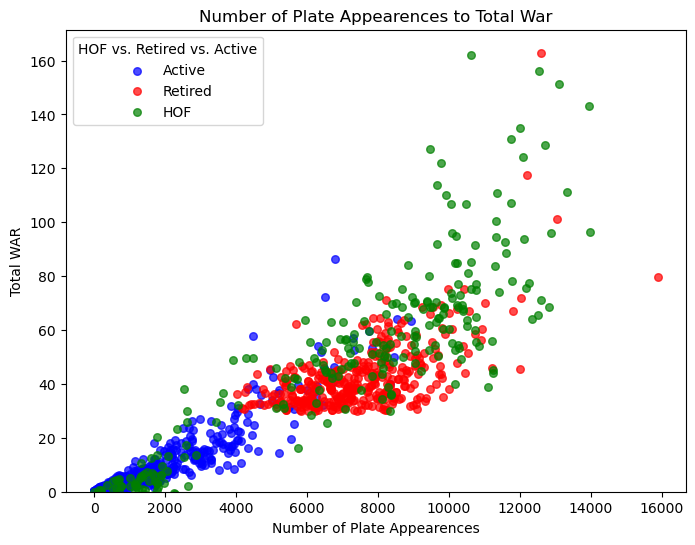

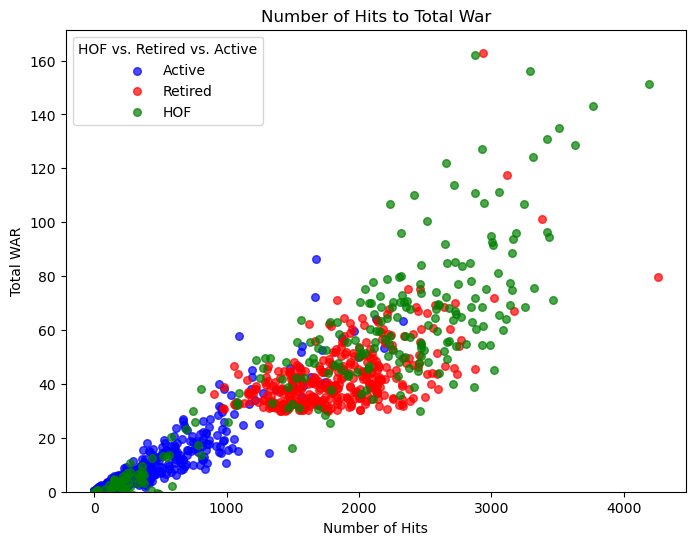

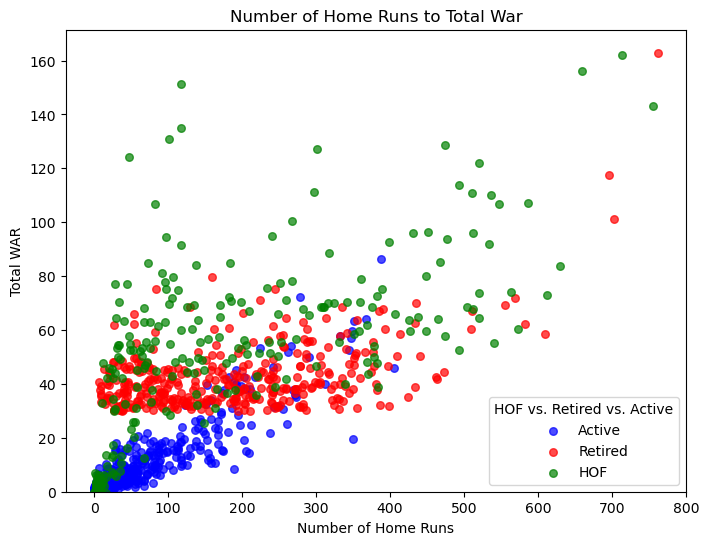

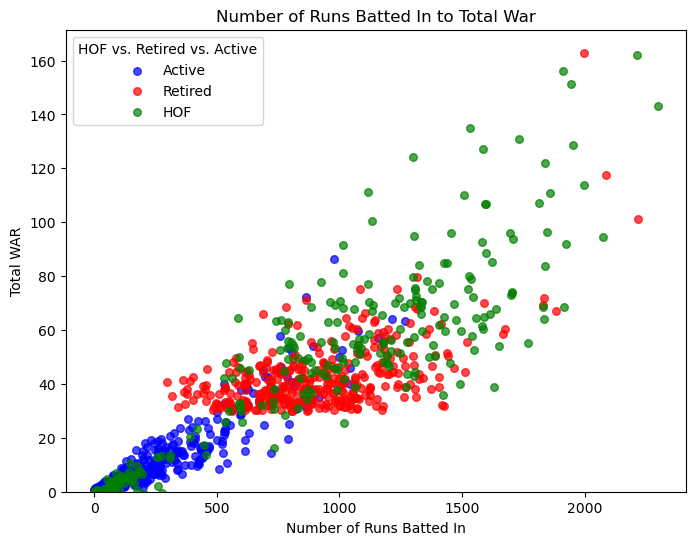

In [15]:
temp_active = players_active.copy()
temp_active = players_active.groupby('Player')[players_active.columns[4:30]].sum().reset_index()

x_cols = ['PA', 'H', 'HR', 'RBI']
stats_cols = ['Plate Appearences', 'Hits', 'Home Runs', 'Runs Batted In']


for index, val in enumerate(x_cols):

    fig, ax = plt.subplots(figsize=(8, 6))
    
    ax.scatter(temp_active[val], temp_active["WAR"], color="blue", label="Active", s=30,
                alpha=0.7)
    ax.scatter(retired_total[val], retired_total["WAR"], color="red", label="Retired", s=30,
                alpha=0.7)
    ax.scatter(hof_total[val], hof_total["WAR"], color="green", label="HOF", s=30,
                alpha=0.7)
    
    ax.set_title(f"Number of {stats_cols[index]} to Total War", fontsize=12)
    ax.set_xlabel(f"Number of {stats_cols[index]}", fontsize=10)
    ax.set_ylabel("Total WAR", fontsize=10)
    ax.set_ylim(0, None)
    ax.legend(title="HOF vs. Retired vs. Active", loc="best")

In [16]:
cluster_inactive = inactive_data.copy()

X = cluster_inactive[cluster_inactive.columns[2:31]].dropna()
X_scaled = StandardScaler().fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)
cluster_inactive = cluster_inactive.loc[X.index].copy()
cluster_inactive['cluster'] = cluster_labels

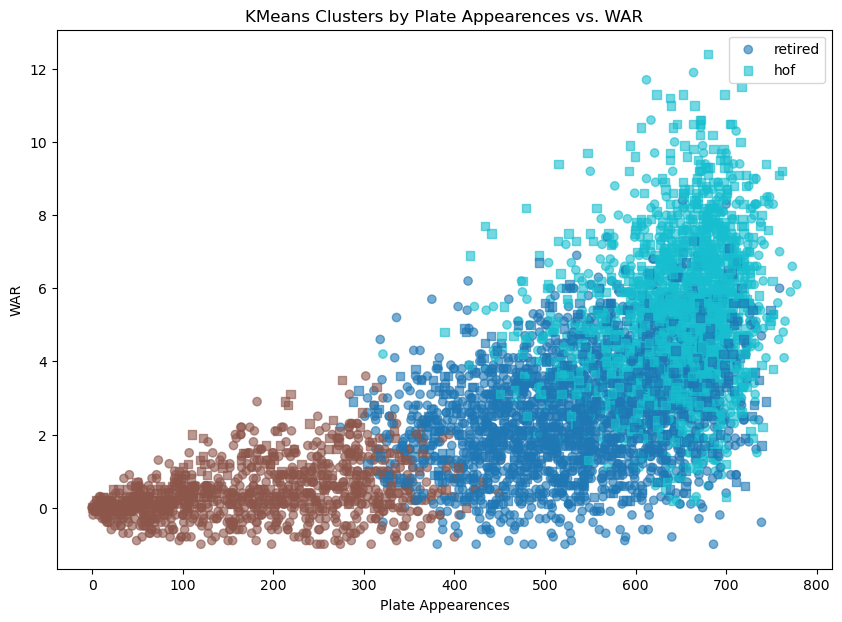

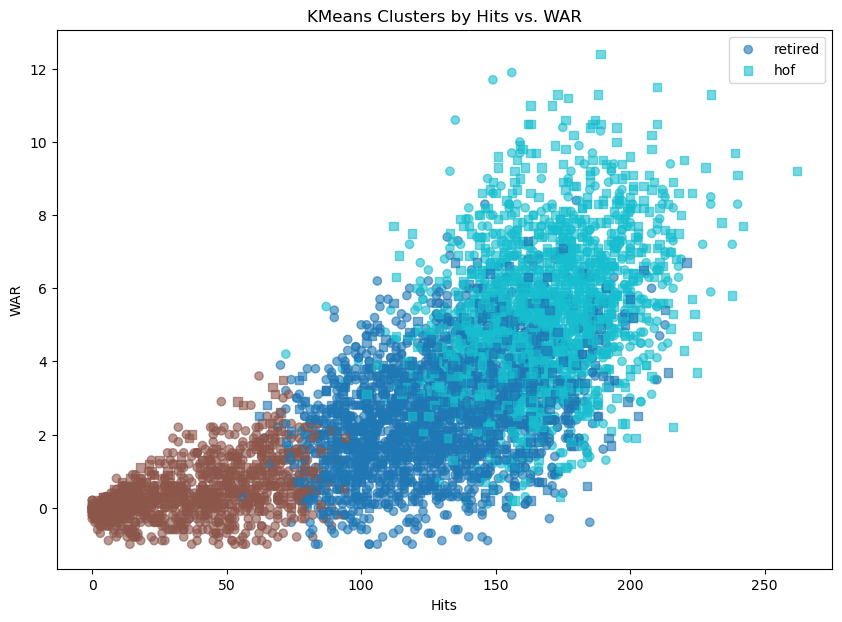

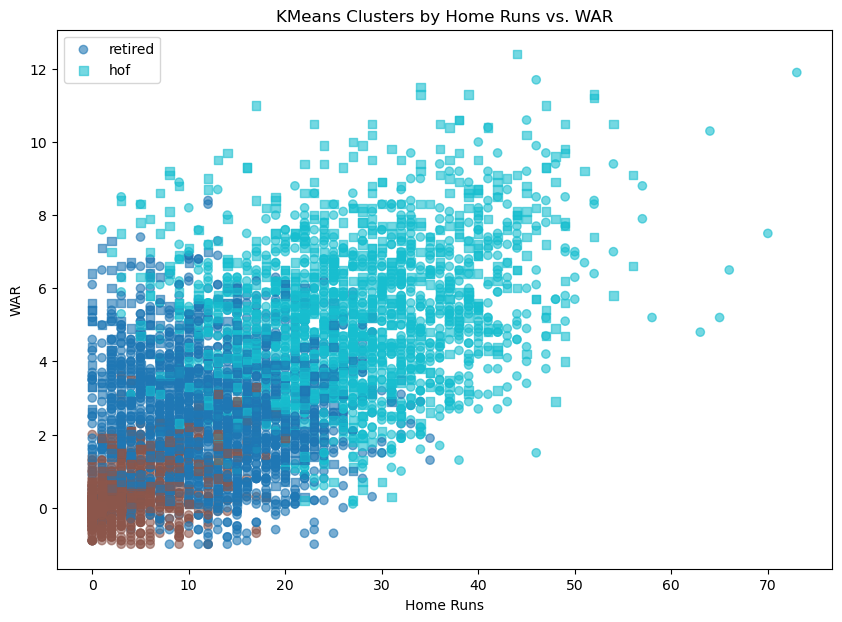

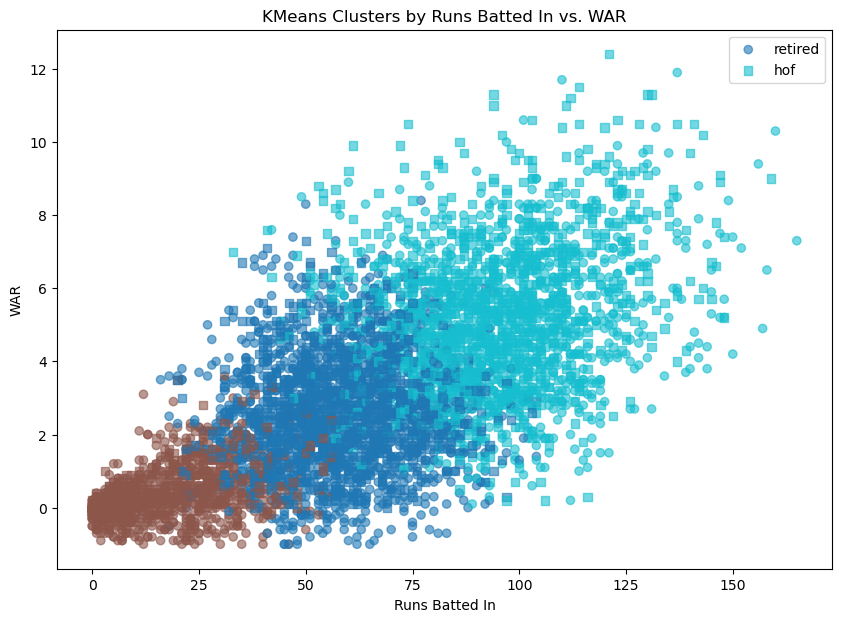

In [17]:
x_cols = ['PA', 'H', 'HR', 'RBI']
stats_cols = ['Plate Appearences', 'Hits', 'Home Runs', 'Runs Batted In']

for index, val in enumerate(x_cols):
    plt.figure(figsize=(10, 7))

    for status, marker in [('retired', 'o'), ('hof', 's')]:
        subset = cluster_inactive[cluster_inactive['status'] == status]
        plt.scatter(subset[val], subset['WAR'],
                    c=subset['cluster'],
                    cmap='tab10',
                    marker=marker,
                    alpha=0.6,
                    label=f"{status}")
    
    plt.xlabel(f"{stats_cols[index]}")
    plt.ylabel("WAR")
    plt.title(f"KMeans Clusters by {stats_cols[index]} vs. WAR")
    plt.legend()
    plt.show()

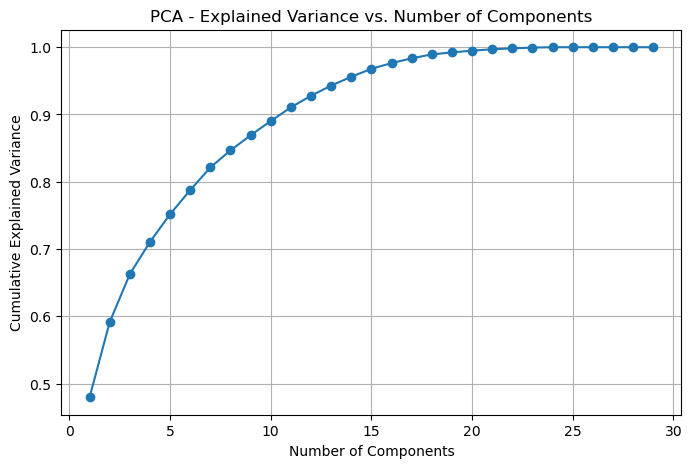

Component 1: 0.4797
Component 2: 0.5914
Component 3: 0.6627
Component 4: 0.7106
Component 5: 0.7518
Component 6: 0.7876
Component 7: 0.8213
Component 8: 0.8466
Component 9: 0.8691
Component 10: 0.8903
Component 11: 0.9106
Component 12: 0.9278
Component 13: 0.9429
Component 14: 0.9561
Component 15: 0.9679
Component 16: 0.9764
Component 17: 0.9835
Component 18: 0.9894
Component 19: 0.9923
Component 20: 0.9949
Component 21: 0.9969
Component 22: 0.9983
Component 23: 0.9994
Component 24: 1.0000
Component 25: 1.0000
Component 26: 1.0000
Component 27: 1.0000
Component 28: 1.0000
Component 29: 1.0000


In [18]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA - Explained Variance vs. Number of Components")
plt.grid(True)
plt.show()

for i, var in enumerate(cumulative_variance):
    print(f"Component {i+1}: {var:.4f}")

<h2><span style="color:blue; font-weight:bold"><u>Soft Clustering Visualization/Analysis</u></span></h2>

<p><span style="color:green; font-weight:bold">The following is some visualizations of the data and player status comparisons using soft clustering.</span></p>

In [30]:
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from itertools import combinations

new_cluster_inactive = inactive_data.copy()

X = new_cluster_inactive[new_cluster_inactive.columns[2:31]].dropna()
X_scaled = StandardScaler().fit_transform(X)

gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=0)
gmm.fit(X_scaled)

probs = gmm.predict_proba(X_scaled)
hard_assignments = np.argmax(probs, axis=1)

pca = PCA(n_components=14)
X_pca = pca.fit_transform(X_scaled)

new_cluster_df= new_cluster_inactive.loc[X.index].copy()
new_cluster_df['cluster'] = hard_assignments

In [31]:
new_cluster_df['cluster_prob0'] = probs[:, 0]

cluster_means = new_cluster_df.groupby('cluster')[['PA', 'H', 'HR', 'RBI']].mean()
print(cluster_means)

                 PA           H         HR        RBI
cluster                                              
0        161.817035   35.269190   4.064143  17.496320
1        477.374413  113.235915  14.325704  58.563967
2        651.170512  166.376613  22.050059  85.818537


In [32]:
new_cluster_df.groupby(['cluster', 'status']).size().unstack().fillna(0)

status,hof,retired
cluster,,
0,191,760
1,379,1325
2,859,1698


Text(0.5, 1.0, 'Season WAR by Cluster and Status (HOF vs Retired)')

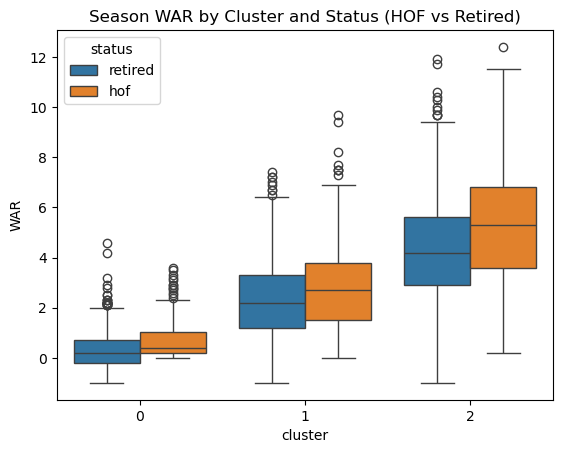

In [33]:
sns.boxplot(data=new_cluster_df, x='cluster', y='WAR', hue='status')
plt.title("Season WAR by Cluster and Status (HOF vs Retired)")

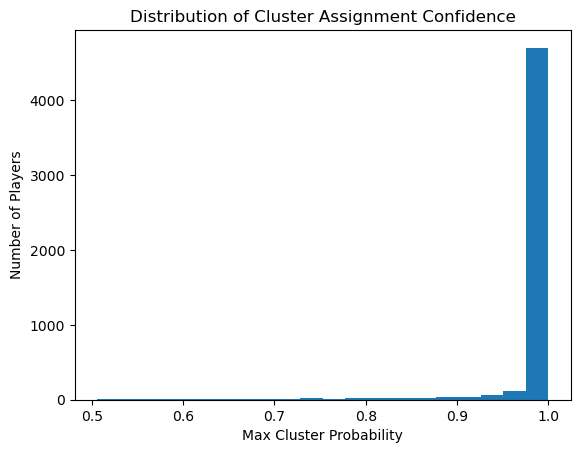

In [34]:
plt.hist(probs.max(axis=1), bins=20)
plt.title("Distribution of Cluster Assignment Confidence")
plt.xlabel("Max Cluster Probability")
plt.ylabel("Number of Players")
plt.show()

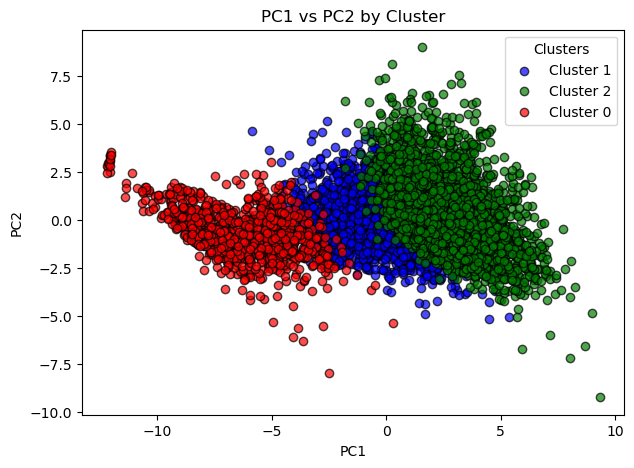

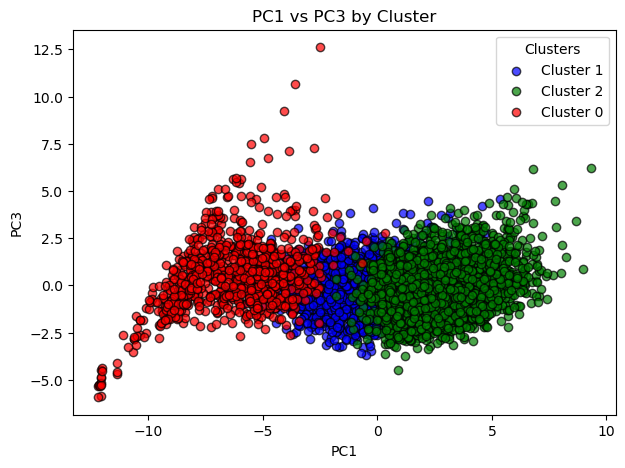

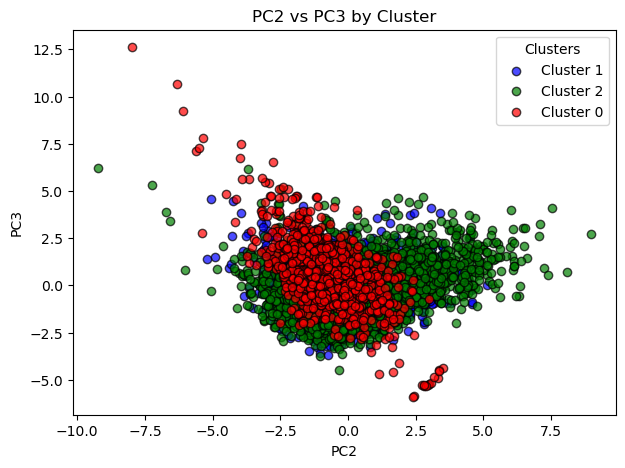

In [35]:
cluster_colors = {
    0: 'red',
    1: 'blue',
    2: 'green'
}

clusters = new_cluster_df['cluster'].unique()
X_pca_subset = X_pca[:, :3]

for i, j in combinations(range(X_pca_subset.shape[1]), 2):
    plt.figure(figsize=(7, 5))
    for cluster_id in clusters:
        idx = new_cluster_df['cluster'] == cluster_id
        plt.scatter(X_pca_subset[idx, i], X_pca_subset[idx, j],
                    color=cluster_colors[cluster_id],
                    label=f'Cluster {cluster_id}', 
                    alpha=0.7, edgecolor='k')
    plt.title(f'PC{i+1} vs PC{j+1} by Cluster')
    plt.xlabel(f'PC{i+1}')
    plt.ylabel(f'PC{j+1}')
    plt.legend(title='Clusters')
    plt.show()

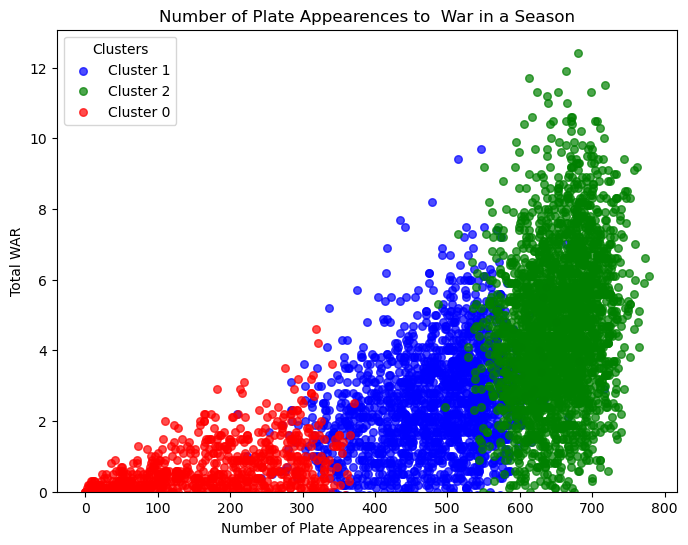

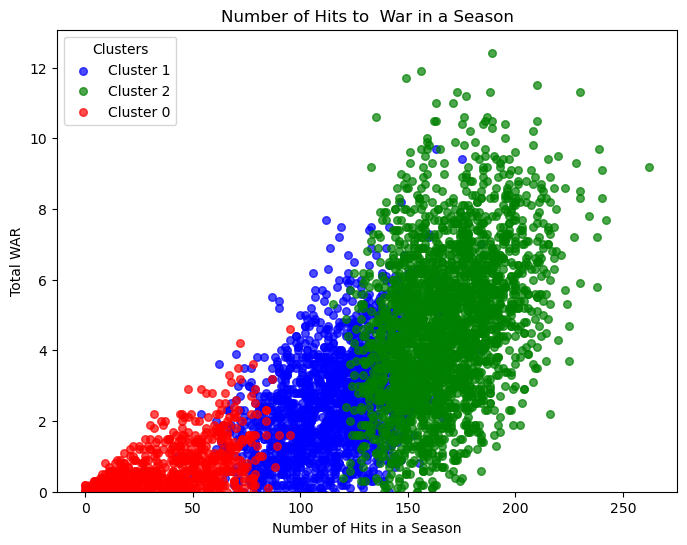

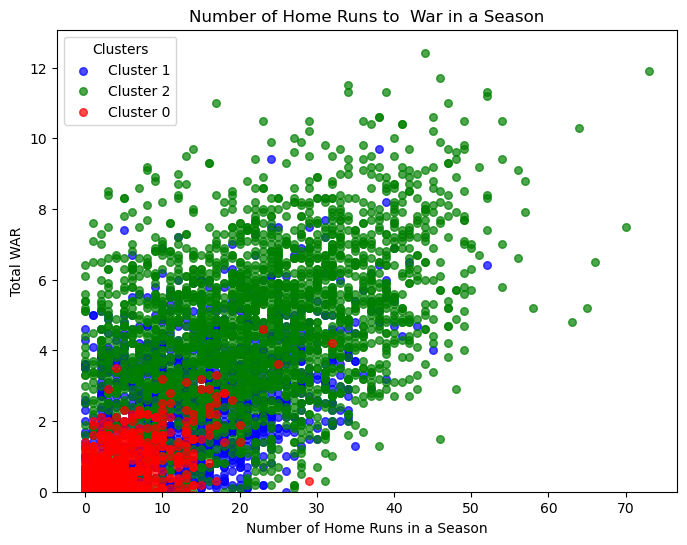

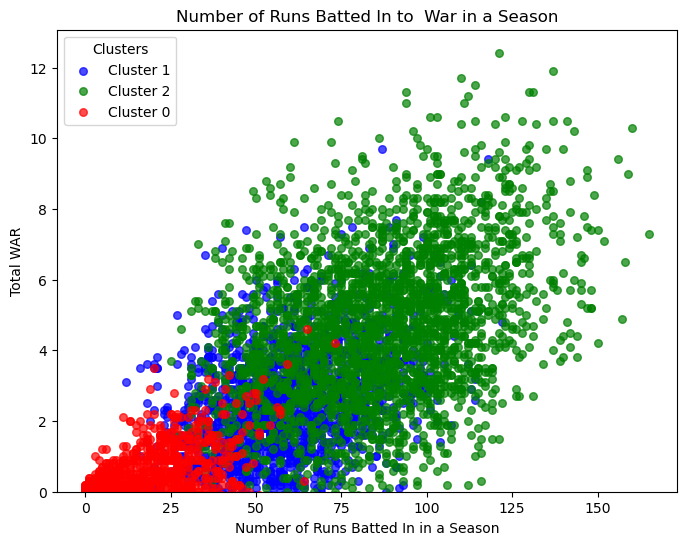

In [36]:
for index, val in enumerate(x_cols):

    fig, ax = plt.subplots(figsize=(8, 6))
    for cluster_id in clusters:
        subset = new_cluster_df[new_cluster_df['cluster'] == cluster_id]
        ax.scatter(subset[val], subset["WAR"], color=cluster_colors[cluster_id], label=f'Cluster {cluster_id}', s=30, alpha=0.7)
    
    ax.set_title(f"Number of {stats_cols[index]} to  War in a Season", fontsize=12)
    ax.set_xlabel(f"Number of {stats_cols[index]} in a Season", fontsize=10)
    ax.set_ylabel("Total WAR", fontsize=10)
    ax.set_ylim(0, None)
    ax.legend(title="Clusters", loc="best")

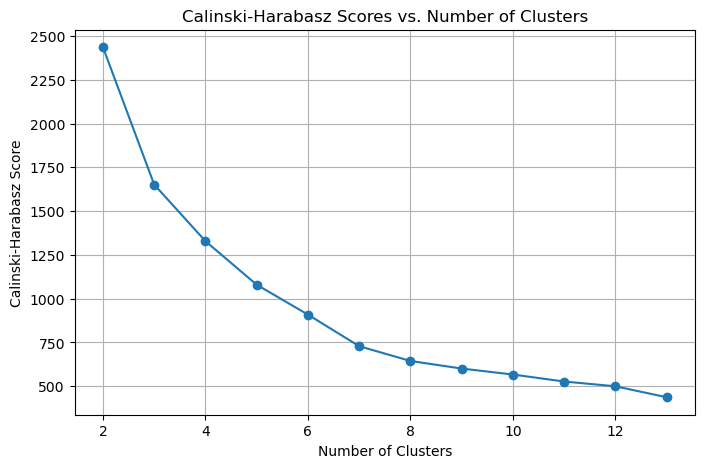

In [40]:
from sklearn.metrics import calinski_harabasz_score

X = new_cluster_inactive[new_cluster_inactive.columns[2:31]].dropna()
X_scaled = StandardScaler().fit_transform(X)

n_components_range = range(2, 14)

calinski_scores = []
valid_components = []

for n in n_components_range:
    gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=0)
    gmm.fit(X_scaled)
    probs = gmm.predict(X_scaled)
    
    score = calinski_harabasz_score(X_scaled, probs)
    calinski_scores.append(score)
    valid_components.append(n)

plt.figure(figsize=(8, 5))
plt.plot(n_components_range, calinski_scores, marker='o')
plt.title("Calinski-Harabasz Scores vs. Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Calinski-Harabasz Score")
plt.grid(True)
plt.show()

best_n = n_components_range[np.argmax(calinski_scores)]